# EN2550 2021: Object Counting on a Convey Belt

In this assignment, you will be counting and tracking the hexagonal nuts on a moving convey belt.

### Let's first import required libraries

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
#from google.colab.patches import cv2_imshow
%matplotlib inline

### Let's load and visualize the template image and the convey belt snapshot at a given time.

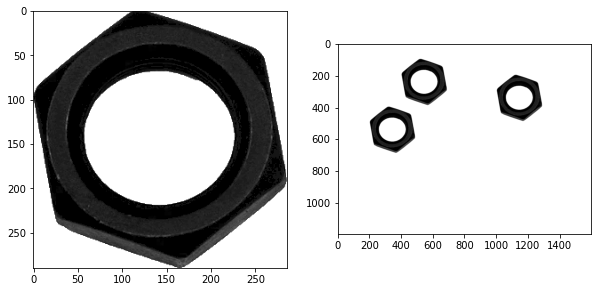

In [2]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE) # image should be grayscale to have a thresholding
belt_im =  cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

## Part-I :

Before going into the implementation, let's play with some functions.

### Otsu's thresholding

Please read thresholding to get an idea about different types of thresholding and how to use them.(Please use cv.THRESH_BINARY_INV).

Threshold value for the template image :  138.0
Threshold value for the belt image :  138.0


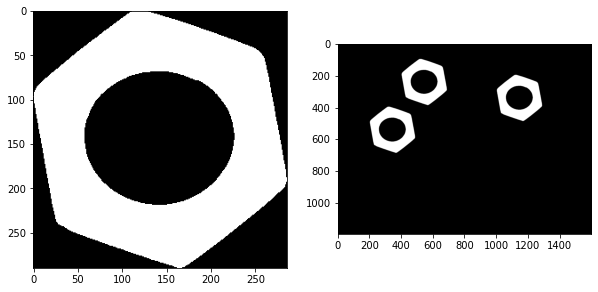

In [3]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) #simple thresholding + Otsu thresholding
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

fig, ax = plt. subplots(1,2,figsize=(10,10))
print("Threshold value for the template image : ",th_t)
print("Threshold value for the belt image : ",th_b)
ax[0].imshow(img_t, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

### Morphological closing

Carry out morphological closing to remove small holes inside the foreground. Use a 3×3 kernel. See closing for a guide.

Closing is reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

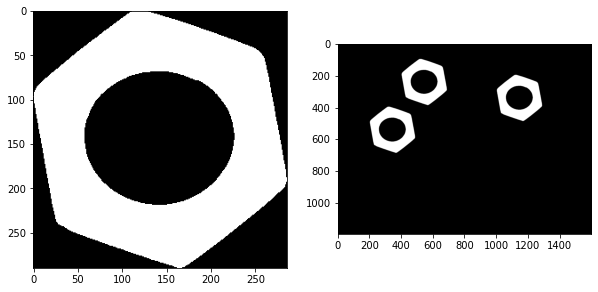

In [4]:
kernel = np.ones((3,3),dtype=np.uint8) 
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel) # obtaining the morphological closing of thresholded images using kernal
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(img_t, cmap='gray')
ax[1].imshow(img_b, cmap='gray')
plt.show()

### Connected component analysis

Apply the connectedComponentsWithStats function (see this).

In [5]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b = cv.connectedComponentsWithStats(closing_b)

How many connected compoonets are detected in each image?

In [6]:
print("Number of connected components detected in the template image : ",retval_t)
print("Number of connected components detected in the belt image : ",retval_b)

Number of connected components detected in the template image :  2
Number of connected components detected in the belt image :  4


What are the statistics? Interpret these statistics.

In [7]:
#Statistics of the template image
print(stats_t)
#Statistics of the belt image
print(stats_b)

[[    0     0   286   290 42290]
 [    0     0   286   290 40650]]
[[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]


What are the centroids?

In [8]:
#Centroid of the template image
print(centroids_t)
#Centroid of the belt image
print(centroids_b)

[[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]
[[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


### Contour analysis

Use findContours function to retrieve the extreme outer contours. (see for help and see for information.)

Display these countours.

In [9]:
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #source image, retrieval mode, contour approximation method
contours_b, hierarchy_b = cv.findContours(closing_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

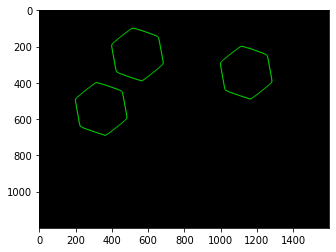

In [10]:
# Visualizing contours
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8') # -1 will draw all the contours
plt.imshow(conts)

### Count the number of matching hexagonal nuts in belt.png.

Use the matchShapes function as shown in examples to match contours in the belt image with that in the template.

Get an idea about the value output by the cv.matchShapes when both the template and the reference image have the same shape. Understand the given code snippet.

In [11]:
label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')   
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)  
for j,c in enumerate(belt_cont):
        print(cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))  # compare two shapes, or two contours and returns a metric showing the similarity

0.00010071698397173812
0.00010071698397950968
0.00010071698397506879


## Part - II

### Frame tracking through image moments.

Use the cv.contourArea(), see this and calculate the the area of the contours_b[1]

In [12]:
ca = cv.contourArea(contours_b[1])
print("Area of the contours_b[1] : ", ca)

Area of the contours_b[1] :  60059.5


Use the cv.moments to extract the x and y coordinates of the centroid of contours_b[1].

Centroid is given by the relations, Cx=M10/M00 and Cy=M01/M00.

In [13]:
M = cv.moments(contours_b[1])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print("Centroid of the contours_b[1] : (",cx,",",cy,")")

Centroid of the contours_b[1] : ( 1142 , 343 )


Make a variable called count to represent the number of contours and set it to the value 1. Make an np array [cx, cy, ca, count] and name this as object_prev_frame

In [14]:
count = 1
object_prev_frame = np.array([cx, cy, ca, count])

Similarly, you can create the object_curr_frame(to describe the current values) and define the threshold delta_x to check whether the corresponding element of both the object_curr_frame and object_prev_frame are less than the delta_x. You can set delta_x as 15 or so. (Here the delta_x can be thought of as the movement of the cx from frame to frame)

In [15]:
delta_x = 15 # can be thought of as the movement of the cx from frame to frame

## Part - III

### 1. Implement the function get_indexed_image, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)

In [16]:
def get_indexed_image(im):
    """ Thresholding, closing, and connected component analysis lumped
    """ 
    threshold_val, threshold_im = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU) # thresholding
    kernel=np.ones((3,3),dtype=np.uint8) 
    closing_im = cv.morphologyEx(threshold_im, cv.MORPH_CLOSE, kernel) # closing
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing_im) # connected component analysis
    return retval, labels, stats, centroids 

### 2. Implement the function is_new, which checks the dissimilarity between 2 vectors. (Grading)

In [17]:
def is_new(a, b, delta, i):
    """ Vector Dissimilarity with an Array of Vectors
    Checks if vector b is similar to a one or more vectors in a outside the tolerances specified in delta. 
    vector i specifies which elements in b to compare with those in a. 
    """
    difference = np.abs(a - b) # Taking the absolute difference 
    'Check whether the absolute different between all the elements of ith column of each array is greater than the ith delta value (See the example in the next cell)'
    difference[:,i] = (difference[:,i] > delta[i]) # comparing each component in the ith column with delta[i]

    return difference[:,i].all() # return true when true for all values


In [18]:
# check is_new  expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert is_new(a, b, delta, i) == False, " Check the function "

### 3. If the array a is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array a is made by stacking all the object_prev_frame for each frame. If b is in the form of [cx, cy, ca, count], write the function prev_index to find the index of a particular nut in the previous frame. (Grading)

In [19]:
def prev_index(a, b, delta, i):
    """ Returns Previous Index
    Returns the index of the apppearance of the object in the previous frame.
    (See the example in the next cell)
    """
    index = -1
    difference = np.abs(a - b) # Taking the absolute difference
    difference[:,i] = (difference[:,i] <= delta[i])
    index = np.where(difference[:,i])[0]
    return index

In [20]:
# check prev_index  expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
 [7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
 [1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])

assert prev_index(a,b,delta,i) == 1, " Check the function "

You can use following code snippet load and access each frame of a video

In [21]:
grayscale_frames =[] # stores grayscale frames
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # vedio location at root directory
while cap.isOpened(): 
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray=cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
    grayscale_frames.append(gray)
    cv.imshow("Frame",frame)
    if cv.waitKey(1) == ord('q'):  
        break

cap.release()
cv.destroyAllWindows()
print(len(grayscale_frames))

Can't receive frame (stream end?). Exiting ...
280


### 3. Implement a code to detect hexagonal nuts in a moving convey belt. (Grading)

#### Steps:

1. Use the above code snippet to access each frame and remember to convert the frame into grey scale. Name the variable as grey
2. Call get_indexed_image and extract retval, labels, stats, centroids.
3. Find contours of all nuts present in a given frame of the belt.
4. Initiate a 3-D array with zeros to draw contours. Call this im_contours_belt
5. Draw each contour. Use cv.drawContours. See this

In [22]:
video = []
contours_list = []
contours_plots = []
for i,im in enumerate (grayscale_frames):
    retval, labels, stats, centroids = get_indexed_image(im) # Call get_indexed_image and extract retval, labels, stats, centroids.
    belt = ((labels >= 1)*255).astype('uint8') 
    contours,hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) # Find contours of all nuts present in a given frame of the belt.
    count = 0 # number of nuts in each frame
    frame = [] # an array to append variables of cinnected components
    for contour in contours:
        metric = cv.matchShapes(contours_t[0], contour, cv.CONTOURS_MATCH_I1, 0.0)
        if metric <= 0.5: 
            count += 1
            M  = cv.moments(contour)
            ca = M['m00']
            cx, cy = int(M['m10']/M['m00']), int(M['m01']/M['m00'])
            frame.append(np.array([cx, cy, ca, count])) # Coordinates of the centroid, Area and nut count
    contours_list.append(contours)
    video.append(frame)
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8) #Initiate a 3-D array with zeros to draw contours. 
    cont = cv.drawContours(im_contours_belt, contours, -1, (0,255,0), 5).astype('uint8') # Draw each contour
    contours_plots.append(cont)
    
    cv.putText(cont,'Frame No:%i'%(i),(1000,200),cv.FONT_HERSHEY_SIMPLEX, 2,(0,255,0),2,cv.LINE_AA)
    cv.imshow('contours',cont)
    if cv.waitKey(1) == ord('q'):  
        break
        
cap.release()
cv.destroyAllWindows()

length of vedio array :  280
[array([1.55100e+03, 4.53000e+02, 5.99425e+04, 1.00000e+00])]
[array([5.62000e+02, 6.53000e+02, 5.99555e+04, 1.00000e+00]), array([1.52000e+02, 3.43000e+02, 6.00575e+04, 2.00000e+00])]


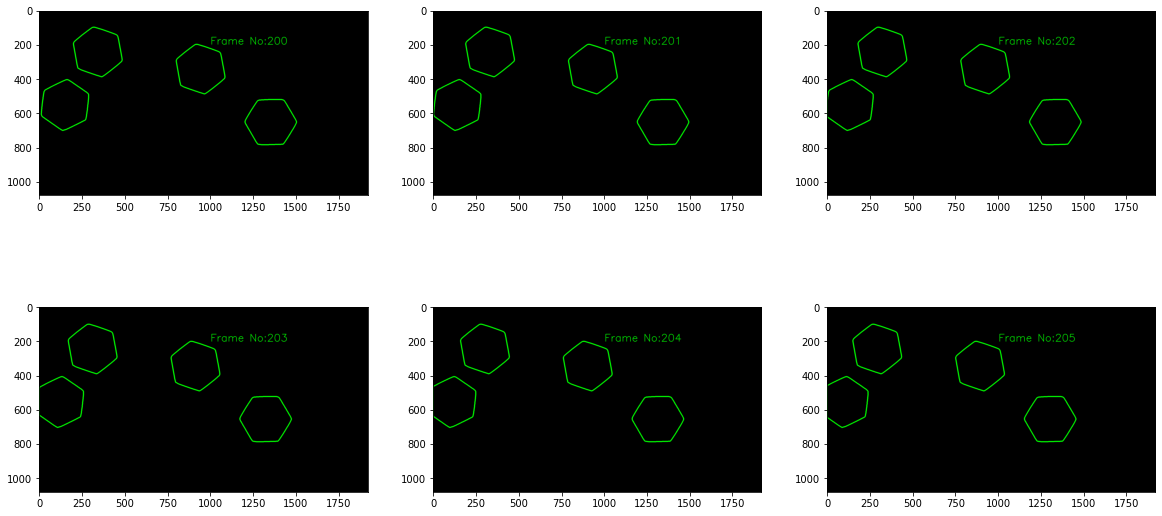

In [23]:
#length of vedio array
print("length of vedio array : ",len(video))
#details contained in the vedio array
print(video[0])
print(video[279])
# Random Conssecative frame value plot
fig,ax=plt.subplots(2,3,figsize=(20,10))
ax[0][0].imshow(contours_plots[200])
ax[0][1].imshow(contours_plots[201])
ax[0][2].imshow(contours_plots[202])
ax[1][0].imshow(contours_plots[203])
ax[1][1].imshow(contours_plots[204])
ax[1][2].imshow(contours_plots[205])
plt.show()

## Object detection and tracking

For each contour of the belt frame,

1. Use is_new and prev_index functions to track each frame and get the indices of each nut.
2. Write a code to detect and track hexagonal nuts in each frame.
3. You may refer, annotation to understand how to add texts and labels to each frame.
4. Output for a random frame would be as follows 

Hint: If you are thresholding on areas (template and contour) you can use 500 as the threshold. You can set the matching threshold to be 0.5 and experiment

In [24]:
total_nuts = int(video[0][-1][-1]) # Initial number of nuts
delta_x = np.array([15])
i = np.array([0])
prev_frame = video[0] 
for j,frame in enumerate(video):
    curr_frame = video[j]
    for nut in frame:
        if is_new(prev_frame, nut, delta_x, i):
            total_nuts +=1
            nut[-1]=total_nuts #Provide a new index if the nut is new
        else:
            index_in_prev_frame = prev_index(prev_frame, nut, delta_x, i) #Provide previous index if the nut is not new
            nut_index = prev_frame[int(index_in_prev_frame)][-1]
            nut[-1] = nut_index # No change in nut index
    prev_frame=curr_frame

Annotation to understand how to add texts and labels to each frame

In [25]:
for frame,cont in zip(video,contours_plots):
    y =0
    for nut in (frame):
        cv.putText(cont,(str(int(nut[-1]))),(int(nut[0]),int(nut[1])),cv.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2,cv.LINE_AA)
        cv.putText(cont,'Object {no} - {cx} , {cy}, {area}'.format(no=int(nut[-1]),cx=nut[0],cy=nut[1],area=nut[2]),(50,850+y*70),cv.FONT_HERSHEY_SIMPLEX, 2,(0,0,255),2,cv.LINE_AA)
        y = y + 1

Output for a random frame would be as follows

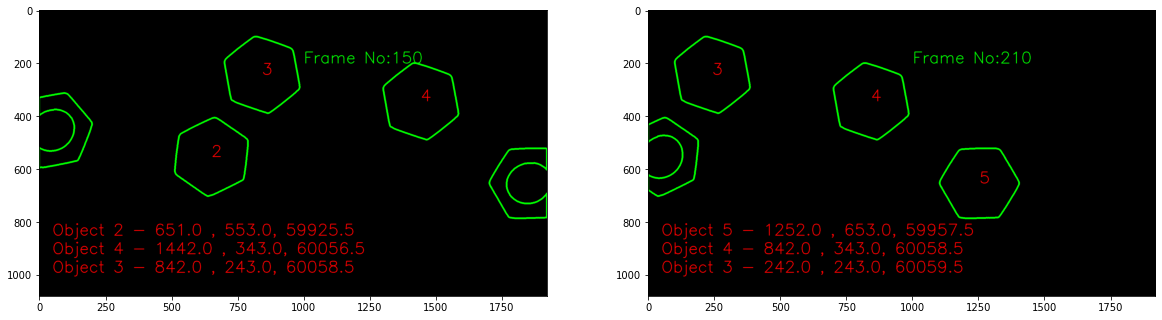

In [28]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(cv.cvtColor(contours_plots[150],cv.COLOR_BGR2RGB)) # Colour conversion
ax[1].imshow(cv.cvtColor(contours_plots[210],cv.COLOR_BGR2RGB))
plt.show()

Creating and saving video

In [27]:
time = 9 #video duration in s
frames_per_second = int(len(contours_plots)/time) # No of frames per second
height, width, channels= contours_plots[0].shape
frame_size = (width, height)
output = cv.VideoWriter('180529E_en2550_a05.mp4', cv.VideoWriter_fourcc(*'MP4V'), frames_per_second, frame_size, True)
for frame in contours_plots:
    output.write(frame)

output.release()